# Médecins et territoires

 - Peut-on établir un lien entre la densité de médecins par spécialité et par territoire et la pratique du dépassement d'honoraires ?
 - Est-ce dans les territoires où la densité est la plus forte que les médecins pratiquent le moins les dépassements d'honoraires ? 
 - Est-ce que la densité de certains médecins / praticiens est corrélée à la densité de population pour certaines classes d'âges (bébé/pédiatre, personnes âgées / infirmiers etc...) ?

C'est un sujet issu du [Hackathon "données de santé" de Etalab](https://www.etalab.gouv.fr/retour-sur-le-premier-hackathon-donnees-de-sante) (la page contient des liens vers différents jeux de données utiles, ainsi que d'autres exemples de questions que vous pouvez préférer aborder). Vous pouvez compléter ça avec des données de l'INSEE et des données sur la [démographie des médecins](http://www.data.drees.sante.gouv.fr/ReportFolders/reportFolders.aspx?IF_ActivePath=P,490,497,514).


## 1. Chargement des données de l'Assurance Maladie

Nous téléchargeons sur le site de l'Assurance Maladie, les données statistiques relatives aux professionnels de santé:

https://www.ameli.fr/l-assurance-maladie/statistiques-et-publications/donnees-statistiques/professionnels-de-sante-liberaux/index.php


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import re

In [2]:
def code_insee(s):

    try:
        dept = re.findall('^\d+[A-B]?', s)[0]
#        if dept == '2':
#            dept = '2' + s[1]
    except:
        dept = None

    return dept

### 1.1 Effectifs et densité

In [3]:
def load_ameli_effectif_et_densite_par_departement(sheetname="Spécialistes"):
    """
    Load 
    ['Spécialistes', 'Généralistes et MEP', 'Dentistes et ODF', 
     'Sages-femmes', 'Auxiliaires médicaux', 'Laboratoires']
    """
    path_to_data = "data/"
    df = pd.read_excel(path_to_data + "ameli_Effectif_et_densite_par_departement_en_2017.xlsx",
                       sheet_name=sheetname)
    
    # rename columns
    new_cols = ['categorie', 'departement', 'effectifs', 'population', 'densite']

    new_name = {}
    for idx, c in enumerate(df.columns[:]):
        new_name[c] = new_cols[idx]
    
    df = df.rename(columns=new_name)
    
    # build code insee
    df['code_insee'] = df['departement'].apply(code_insee)
    
        # correct categorie
    df['categorie'] = df['categorie'].replace(to_replace='TOTAL CHIRURGIE  (43, 44, 46, 47, 48, 49, 04, 10, 16 ,41)',
                                              value='TOTAL CHIRURGIE  (43, 44, 46, 47, 48, 49, 04, 10, 16, 41)')
 

    # Remove 'null' values
    df = df.dropna()
    
    return df

df_specialiste = load_ameli_effectif_et_densite_par_departement(sheetname="Spécialistes")

df_specialiste[df_specialiste['departement'] == '69- Rhône'].head()

,categorie,departement,effectifs,population,densite,code_insee
69,02- Anesthésie-réanimation chirurgicale,69- Rhône,189,1.878100e+06,10.063363,69
173,20- Réanimation médicale,69- Rhône,0,1.878100e+06,0.000000,69
277,"TOTAL ANESTHESIE REANIMATION (02, 20)",69- Rhône,189,1.878100e+06,10.063363,69
381,03- Pathologie cardio-vasculaire,69- Rhône,133,1.878100e+06,7.081625,69
485,43- Chirurgie infantile,69- Rhône,11,1.878100e+06,0.585698,69


In [4]:
col_list = [s for s in df_specialiste['categorie'].unique() if s.startswith("TOTAL")]

print(col_list)

['TOTAL ANESTHESIE REANIMATION  (02, 20)', 'TOTAL CHIRURGIE  (43, 44, 46, 47, 48, 49, 04, 10, 16, 41)', 'TOTAL RADIOLOGIE  (72, 74, 76, 06)', 'TOTAL GYNECOLOGIE  (70, 77, 79, 07)', 'TOTAL MEDECINE INTERNE  (71, 73, 09)', 'TOTAL PEDIATRIE  (78, 12)', 'TOTAL STOMATOLOGIE  (69, 45, 18)', 'TOTAL PSYCHIATRIE  (75, 33, 17)', 'TOTAL SPECIALISTES', 'TOTAL MEDECINS']


In [5]:
df_specialiste['code_insee'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '2A', '2B', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
       '88', '89', '90', '91', '92', '93', '94', '95', '971', '972',
       '973', '974', '976'], dtype=object)

In [6]:
df_specialiste.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5555 entries, 0 to 5717
Data columns (total 6 columns):
categorie      5555 non-null object
departement    5555 non-null object
effectifs      5555 non-null int64
population     5555 non-null float64
densite        5555 non-null float64
code_insee     5555 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 303.8+ KB


In [7]:
def load_ameli_effectif_et_densite_par_region(sheetname="Spécialistes"):
    """
    ['Spécialistes', 'Généralistes et MEP', 'Dentistes et ODF', 
     'Sages-femmes', 'Auxiliaires médicaux', 'Laboratoires']
    """
    path_to_data = "data/"
    df = pd.read_excel(path_to_data + "ameli_Effectif_et_densite_par_region_en_2017.xlsx",
                       sheet_name=sheetname)
    
    # rename columns
    new_cols = ['categorie', 'departement', 'effectifs', 'population', 'densite']

    new_name = {}
    for idx, c in enumerate(df.columns[:]):
        new_name[c] = new_cols[idx]
    
    df = df.rename(columns=new_name)
    
    #build code insee
    df['code_insee'] = df['departement'].apply(code_insee)
    
    return df

### 1.2 Honoraires

In [8]:
def load_ameli_honoraires_par_departement(sheetname="Spécialistes"):
    """
    ['Spécialistes', 'Généralistes et MEP', 'Dentistes et ODF', 
     'Sages-femmes', 'Auxiliaires médicaux', 'Laboratoires']
    """
    path_to_data = "data/"
    df = pd.read_excel(path_to_data + "ameli_Honoraires_totaux_des_professionnels_de_sante_par_departement_en_2017.xlsx",
                       sheet_name=sheetname)
    
    # rename columns
    new_cols = ['categorie', 'departement', 'effectifs', 'honoraires_sans_depassement', 'depassement',
                'deplacement', 'honoraires_total']

    new_name = {}
    for idx, c in enumerate(df.columns[:]):
        new_name[c] = new_cols[idx]
    
    df = df.rename(columns=new_name)
    
    # NaN
    df['honoraires_sans_depassement'] = df['honoraires_sans_depassement'].apply(pd.to_numeric, errors='coerce')
    df['depassement'] = df['depassement'].apply(pd.to_numeric, errors='coerce')
    df['deplacement'] = df['deplacement'].apply(pd.to_numeric, errors='coerce')
    df['honoraires_total'] = df['honoraires_total'].apply(pd.to_numeric, errors='coerce')
    
    # create new column 'depassement_pc'
    df['depassement_pc'] = df['depassement'] / df['honoraires_total'] * 100
    
    # build code insee
    df['code_insee'] = df['departement'].apply(code_insee)
    
    # correct categorie
    df['categorie'] = df['categorie'].replace(to_replace='TOTAL CHIRURGIE  (43, 44, 46, 47, 48, 49, 04,10, 16, 41)',
                                              value='TOTAL CHIRURGIE  (43, 44, 46, 47, 48, 49, 04, 10, 16, 41)')
    
    # Remove 'null' values
    df = df.dropna()
    
    return df

honoraires_specialistes = load_ameli_honoraires_par_departement("Spécialistes")

honoraires_specialistes.head()

,categorie,departement,effectifs,honoraires_sans_depassement,depassement,deplacement,honoraires_total,depassement_pc,code_insee
0,02- Anesthésie-réanimation chirurgicale,01- Ain,17,4675795.92,2548194.45,0.0,7223990.37,35.274057,01
1,02- Anesthésie-réanimation chirurgicale,02- Aisne,18,5196860.22,388808.16,0.0,5585668.38,6.960817,02
2,02- Anesthésie-réanimation chirurgicale,03- Allier,17,4738207.65,530489.48,0.0,5268697.13,10.068703,03
5,02- Anesthésie-réanimation chirurgicale,06- Alpes-Maritimes,108,25614553.58,11165710.59,0.0,36780264.17,30.357886,06
6,02- Anesthésie-réanimation chirurgicale,07- Ardèche,21,5613968.70,798986.69,0.0,6412955.39,12.458947,07


In [9]:
col_list = [s for s in honoraires_specialistes['categorie'].unique() if s.startswith("TOTAL")]

print(col_list)

['TOTAL ANESTHESIE REANIMATION  (02, 20)', 'TOTAL CHIRURGIE  (43, 44, 46, 47, 48, 49, 04, 10, 16, 41)', 'TOTAL RADIOLOGIE  (72, 74, 76, 06)', 'TOTAL GYNECOLOGIE  (70, 77, 79, 07)', 'TOTAL MEDECINE INTERNE  (71, 73, 09)', 'TOTAL PEDIATRIE  (78, 12)', 'TOTAL STOMATOLOGIE  (69, 45, 18)', 'TOTAL PSYCHIATRIE  (75, 33, 17)', 'TOTAL SPECIALISTES', 'TOTAL MEDECINS']


In [10]:
honoraires_specialistes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1896 entries, 0 to 5711
Data columns (total 9 columns):
categorie                      1896 non-null object
departement                    1896 non-null object
effectifs                      1896 non-null int64
honoraires_sans_depassement    1896 non-null float64
depassement                    1896 non-null float64
deplacement                    1896 non-null float64
honoraires_total               1896 non-null float64
depassement_pc                 1896 non-null float64
code_insee                     1896 non-null object
dtypes: float64(5), int64(1), object(3)
memory usage: 148.1+ KB


## 2. Chargement des données INSEE

Nous téléchargeons sur le site de l'INSEE, les données statistiques relatives à la population:

https://www.insee.fr/fr/statistiques/1893198

https://www.insee.fr/fr/statistiques/2012692#tableau-TCRD_021_tab1_departements

### 2.1 Densité population

In [11]:
def load_insee_pop_par_dep_et_reg(sheetname='DEP'):

    path_to_data = "data/"

    df = pd.read_excel(path_to_data + "INSEE_pop_par_DEP_et_REG.xlsx",
                       sheet_name=sheetname, skiprows=3)

    # rename columns
    new_cols = ['id', 'id_name', 'all', 'femmes', 'hommes',
                '0-24', '25-59', '+60', '+75']

    new_name = {}
    for idx, c in enumerate(df.columns[:]):
        new_name[c] = new_cols[idx]
    
    return df.rename(columns=new_name)

In [12]:
# departements
pop_dep = load_insee_pop_par_dep_et_reg('DEP')

pop_dep.head(10)

,id,id_name,all,femmes,hommes,0-24,25-59,+60,+75
0,01,Ain,653688.0,50.8,49.2,30.4,45.8,23.8,8.1
1,02,Aisne,528016.0,51.3,48.7,29.6,43.1,27.3,9.1
2,03,Allier,333065.0,52.1,47.9,24.4,40.7,34.9,13.3
3,04,Alpes-de-Haute-Provence,161980.0,51.1,48.9,24.6,41.5,34.0,12.7
4,05,Hautes-Alpes,141784.0,51.0,49.0,25.5,42.9,31.6,11.6
5,06,Alpes-Maritimes,1080899.0,52.8,47.2,26.0,43.2,30.8,12.6
6,07,Ardèche,327011.0,51.2,48.8,25.7,42.3,32.1,11.6
7,08,Ardennes,267409.0,51.4,48.6,27.4,43.5,29.2,10.0
8,09,Ariège,152340.0,50.8,49.2,24.6,41.8,33.6,12.6
9,10,Aube,309117.0,51.5,48.5,29.5,42.5,28.0,9.9


In [13]:
pop_dep['id'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '2A', '2B', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
       '88', '89', '90', '91', '92', '93', '94', '95', 'P', 'M', '971',
       '972', '973', '974', '976', 'F',
       'Source : Insee, estimations de population (données provisoires)'],
      dtype=object)

In [14]:
# regions
pop_reg = load_insee_pop_par_dep_et_reg('REG')

pop_reg.head(10)

,id,id_name,all,femmes,hommes,0-24,25-59,+60,+75
0,84,Auvergne-Rhône-Alpes,8026685.0,51.4,48.6,29.9,44.3,25.8,9.3
1,27,Bourgogne-Franche-Comté,2795301.0,51.3,48.7,27.7,42.4,29.9,10.8
2,53,Bretagne,3329395.0,51.4,48.6,28.6,42.5,28.9,10.4
3,24,Centre-Val de Loire,2566759.0,51.6,48.4,28.3,42.5,29.2,10.7
4,94,Corse,339178.0,51.6,48.4,24.8,45.1,30.0,11.5
5,44,Grand Est,5518188.0,51.3,48.7,28.6,44.5,26.9,9.4
6,32,Hauts-de-France,5978266.0,51.5,48.5,31.7,44.1,24.2,7.9
7,11,Île-de-France,12213364.0,51.8,48.2,32.0,47.7,20.2,6.8
8,28,Normandie,3319067.0,51.7,48.3,29.2,42.7,28.2,9.9
9,75,Nouvelle-Aquitaine,5987014.0,51.8,48.2,26.8,42.6,30.6,11.3


### 2.2 Densité population par département et tranche d'age

Il y a plusieurs degrés de finesse dans les classes d'age: par tranche de 20 ans (gca) ou par tranche de 5 ans (aq). 

In [15]:
def load_insee_pop_dep_sexe_gca(sheetname='2018'):
    """
    classe 20 ans
    """
    path_to_data = "data/"

    df = pd.read_excel(path_to_data + "INSEE-pop-dep-sexe-gca-1975-2019.xlsx",
                       sheet_name=sheetname, skiprows=3)

    # rename columns
    new_cols = ['dept', 'dept_name',
                'all_00-19', 'all_20-39', 'all_40-59', 'all_60-74', 'all_75+', 'all_total',
                'hom_00-19', 'hom_20-39', 'hom_40-59', 'hom_60-74', 'hom_75+', 'hom_total',
                'fem_00-19', 'fem_20-39', 'fem_40-59', 'fem_60-74', 'fem_75+', 'fem_total']

    new_name = {}
    for idx, c in enumerate(df.columns[:]):
        new_name[c] = new_cols[idx]
    
    df = df.rename(columns=new_name)

    # remove first row
    df.drop(df.head(1).index, inplace=True)

    df = df.dropna(subset=['dept_name'])
    return df

def load_insee_pop_dep_sexe_aq(sheetname='2018'):
    """
    Classe quinquennal
    """
    path_to_data = "data/"

    df = pd.read_excel(path_to_data + "INSEE-pop-dep-sexe-aq-1975-2019.xlsx",
                       sheet_name=sheetname, skiprows=3)

    # rename columns
    new_cols = ['dept', 'dept_name',
                'all_00-04', 'all_05-09', 'all_10-14', 'all_15-19', 'all_20-24', 'all_25-29', 
                'all_30-34', 'all_35-39', 'all_40-44', 'all_45-49', 'all_50-54', 'all_55-59',
                'all_60-64', 'all_65-69', 'all_70-74', 'all_75-79', 'all_80-84', 'all_85-89',
                'all_90-94', 'all_95+', 'all_total',
                'hom_00-04', 'hom_05-09', 'hom_10-14', 'hom_15-19', 'hom_20-24', 'hom_25-29', 
                'hom_30-34', 'hom_35-39', 'hom_40-44', 'hom_45-49', 'hom_50-54', 'hom_55-59',
                'hom_60-64', 'hom_65-69', 'hom_70-74', 'hom_75-79', 'hom_80-84', 'hom_85-89',
                'hom_90-94', 'hom_95+', 'hom_total',
                'fem_00-04', 'fem_05-09', 'fem_10-14', 'fem_15-19', 'fem_20-24', 'fem_25-29', 
                'fem_30-34', 'fem_35-39', 'fem_40-44', 'fem_45-49', 'fem_50-54', 'fem_55-59',
                'fem_60-64', 'fem_65-69', 'fem_70-74', 'fem_75-79', 'fem_80-84', 'fem_85-89',
                'fem_90-94', 'fem_95+', 'fem_total']

    new_name = {}
    for idx, c in enumerate(df.columns[:]):
        new_name[c] = new_cols[idx]
    
    df = df.rename(columns=new_name)

    # remove first row
    df.drop(df.head(1).index, inplace=True)

    df = df.dropna(subset=['dept_name'])
    return df

pop_dep3 = load_insee_pop_dep_sexe_aq('2018')

pop_dep3.head()

,dept,dept_name,all_00-04,all_05-09,all_10-14,all_15-19,all_20-24,all_25-29,all_30-34,all_35-39,...,fem_55-59,fem_60-64,fem_65-69,fem_70-74,fem_75-79,fem_80-84,fem_85-89,fem_90-94,fem_95+,fem_total
1,01,Ain,38964,44765,44798,39081,30392,35502,40748,43421,...,21115,19354,18322,14158,9962,8899,7152,3572,1131,329065
2,02,Aisne,30542,34867,35099,33001,24778,28042,31054,32153,...,18249,18024,17892,12969,9209,9081,7268,3653,934,272482
3,03,Allier,15102,17160,18578,17855,13851,15247,15878,17730,...,12285,13044,13413,11372,8025,8360,6637,3352,1017,174753
4,04,Alpes-de-Haute-Provence,7555,8713,9292,8754,6060,7159,8310,8769,...,6148,5934,6117,5282,3874,3405,2580,1478,479,83055
5,05,Hautes-Alpes,6864,8073,8321,7529,5690,6738,7525,8700,...,5076,5143,5121,4030,2948,2709,2200,1157,736,72238


In [16]:
pop_dep3.shape

(101, 65)

In [17]:
pop_dep3.tail(101)

,dept,dept_name,all_00-04,all_05-09,all_10-14,all_15-19,all_20-24,all_25-29,all_30-34,all_35-39,...,fem_55-59,fem_60-64,fem_65-69,fem_70-74,fem_75-79,fem_80-84,fem_85-89,fem_90-94,fem_95+,fem_total
1,01,Ain,38964,44765,44798,39081,30392,35502,40748,43421,...,21115,19354,18322,14158,9962,8899,7152,3572,1131,329065
2,02,Aisne,30542,34867,35099,33001,24778,28042,31054,32153,...,18249,18024,17892,12969,9209,9081,7268,3653,934,272482
3,03,Allier,15102,17160,18578,17855,13851,15247,15878,17730,...,12285,13044,13413,11372,8025,8360,6637,3352,1017,174753
4,04,Alpes-de-Haute-Provence,7555,8713,9292,8754,6060,7159,8310,8769,...,6148,5934,6117,5282,3874,3405,2580,1478,479,83055
5,05,Hautes-Alpes,6864,8073,8321,7529,5690,6738,7525,8700,...,5076,5143,5121,4030,2948,2709,2200,1157,736,72238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,971,Guadeloupe,20565,24353,28062,26598,18039,18050,17880,19850,...,15884,14143,12297,9557,6950,5666,3540,1933,741,209659
99,972,Martinique,17297,20661,23134,23451,16735,17058,17334,17626,...,16519,14297,12247,9485,7751,6207,3923,2203,1272,199046
100,973,Guyane,31563,30506,30552,27255,19383,19955,20575,21086,...,5902,4462,3155,2017,1188,804,535,282,114,144825
101,974,La Réunion,61366,67091,70696,68816,50632,50310,51505,54098,...,28487,24520,18454,12810,10350,7731,4194,1952,685,448613


## 3. Analyse des données

### 3.1 Spécialistes

#### 3.1.1 Densité

In [18]:
df_specialistes_d = load_ameli_effectif_et_densite_par_departement(sheetname="Spécialistes")

df_specialistes_d = df_specialistes_d[['categorie', 'code_insee', 'densite']]

table_d = df_specialistes_d.pivot(index='code_insee', columns='categorie', values='densite')

table_d.head(30)

categorie,02- Anesthésie-réanimation chirurgicale,03- Pathologie cardio-vasculaire,04- Chirurgie générale,05- Dermato-vénéréologie,06- Radiodiagnostic et imagerie médicale,07- Gynécologie obstétrique,08- Gastro-entérologie et hépatologie,09- Médecine interne,10- Neurochirurgie,11- Oto-rhino-laryngologie,...,"TOTAL ANESTHESIE REANIMATION (02, 20)","TOTAL CHIRURGIE (43, 44, 46, 47, 48, 49, 04, 10, 16, 41)","TOTAL GYNECOLOGIE (70, 77, 79, 07)","TOTAL MEDECINE INTERNE (71, 73, 09)",TOTAL MEDECINS,"TOTAL PEDIATRIE (78, 12)","TOTAL PSYCHIATRIE (75, 33, 17)","TOTAL RADIOLOGIE (72, 74, 76, 06)",TOTAL SPECIALISTES,"TOTAL STOMATOLOGIE (69, 45, 18)"
code_insee,,,,,,,,,,,,,,,,,,,,,
01,2.616592,3.386178,1.077420,1.847006,6.002771,2.308758,2.000924,0.000000,0.000000,1.693089,...,2.616592,4.617516,2.770510,0.000000,104.971532,1.847006,1.539172,6.464522,37.709714,0.615669
02,3.368894,4.679020,1.122965,2.620251,5.801984,4.866180,2.807412,0.374322,0.000000,2.620251,...,3.368894,5.801984,5.801984,1.122965,126.520689,2.433090,4.866180,6.363467,54.089466,0.561482
03,5.014750,7.374632,1.179941,2.949853,8.554573,4.424779,2.949853,0.000000,0.000000,2.654867,...,5.014750,10.324484,5.309735,0.294985,155.457237,0.294985,4.424779,9.734514,66.961656,0.589971
04,2.473717,6.802722,0.618429,3.710575,5.565863,3.092146,3.710575,0.618429,0.000000,3.710575,...,2.473717,4.329005,4.947434,1.236858,178.107618,3.092146,5.565863,5.565863,61.842923,0.618429
05,3.531074,8.474577,2.118644,5.649718,7.062147,1.412429,4.237288,1.412429,0.000000,4.943503,...,3.531074,15.536724,2.824859,1.412429,197.740125,1.412429,3.531074,7.062147,77.683621,0.000000
06,9.994448,13.325931,4.071812,9.624283,13.603554,10.734778,5.830095,1.017953,0.462706,6.015177,...,9.994448,19.803814,13.511013,1.943365,268.832147,6.292801,18.508237,15.084213,150.657052,1.850824
07,6.390749,5.477785,3.651857,2.434571,5.477785,0.608643,1.217286,0.000000,0.000000,3.651857,...,6.390749,10.651248,5.477785,0.000000,143.944014,3.043214,2.738892,5.477785,56.299456,0.304321
08,2.211574,5.160339,2.211574,2.211574,5.897531,2.948765,2.948765,0.368596,0.368596,1.842978,...,2.211574,5.160339,4.423148,0.368596,133.431634,2.211574,4.054552,7.003318,46.443055,0.737191
09,0.000000,2.626395,1.969797,0.656599,4.596192,2.626395,1.969797,0.000000,0.000000,2.626395,...,0.000000,4.596192,3.939593,0.000000,141.825353,1.969797,4.596192,4.596192,41.365728,0.656599


#### 3.1.2 Honoraires

In [19]:
df_specialistes_h = load_ameli_honoraires_par_departement(sheetname="Spécialistes")

df_specialistes_h = df_specialistes_h[['categorie', 'code_insee', 'depassement_pc']]

table_h = df_specialistes_h.pivot(index='code_insee', columns='categorie', values='depassement_pc')

filter_col = [col for col in table_h if col.startswith("TOTAL")]

#print(filter_col)

table_h[filter_col].head(100)

categorie,"TOTAL ANESTHESIE REANIMATION (02, 20)","TOTAL CHIRURGIE (43, 44, 46, 47, 48, 49, 04, 10, 16, 41)","TOTAL GYNECOLOGIE (70, 77, 79, 07)","TOTAL MEDECINE INTERNE (71, 73, 09)",TOTAL MEDECINS,"TOTAL PEDIATRIE (78, 12)","TOTAL PSYCHIATRIE (75, 33, 17)","TOTAL RADIOLOGIE (72, 74, 76, 06)",TOTAL SPECIALISTES,"TOTAL STOMATOLOGIE (69, 45, 18)"
code_insee,,,,,,,,,,
01,35.274057,30.343861,25.019724,NaN,10.810057,6.931034,NaN,12.211244,19.692562,NaN
02,6.960817,14.782015,8.837866,NaN,4.124318,3.422856,5.487809,0.669536,6.902566,NaN
03,10.068703,21.108127,16.995855,NaN,5.586362,NaN,4.704000,0.525585,9.169113,NaN
04,NaN,NaN,NaN,NaN,5.221665,NaN,NaN,NaN,9.712548,NaN
05,NaN,8.654415,NaN,NaN,2.650527,NaN,NaN,NaN,4.437650,NaN
...,...,...,...,...,...,...,...,...,...,...
95,26.805349,34.716049,34.486108,NaN,16.217469,17.178594,21.837108,13.790993,22.299189,48.044805
971,1.256974,12.290884,5.857806,NaN,3.881649,3.237722,NaN,2.438039,5.987858,NaN
972,24.781509,34.508119,17.441098,NaN,7.337040,14.376616,NaN,5.810155,13.233255,NaN


In [20]:
table_h.corrwith(table_d, axis=0).sort_values(ascending=False)

categorie
43- Chirurgie infantile                                      1.000000
73- Oncologie médicale                                       0.994766
34-Gériatrie                                                 0.988437
48- Chirurgie vasculaire                                     0.970455
TOTAL MEDECINE INTERNE  (71, 73, 09)                         0.858488
17- Neuropsychiatrie                                         0.832473
09- Médecine interne                                         0.800847
12- Pédiatrie                                                0.668896
TOTAL PEDIATRIE  (78, 12)                                    0.668401
TOTAL GYNECOLOGIE  (70, 77, 79, 07)                          0.603432
TOTAL SPECIALISTES                                           0.595636
10- Neurochirurgie                                           0.552946
07- Gynécologie obstétrique                                  0.538510
TOTAL MEDECINS                                               0.508692
TOTAL CHIR

In [21]:
filter_col = [col for col in table_h if col.startswith("TOTAL")]
print(filter_col)

['TOTAL ANESTHESIE REANIMATION  (02, 20)', 'TOTAL CHIRURGIE  (43, 44, 46, 47, 48, 49, 04, 10, 16, 41)', 'TOTAL GYNECOLOGIE  (70, 77, 79, 07)', 'TOTAL MEDECINE INTERNE  (71, 73, 09)', 'TOTAL MEDECINS', 'TOTAL PEDIATRIE  (78, 12)', 'TOTAL PSYCHIATRIE  (75, 33, 17)', 'TOTAL RADIOLOGIE  (72, 74, 76, 06)', 'TOTAL SPECIALISTES', 'TOTAL STOMATOLOGIE  (69, 45, 18)']


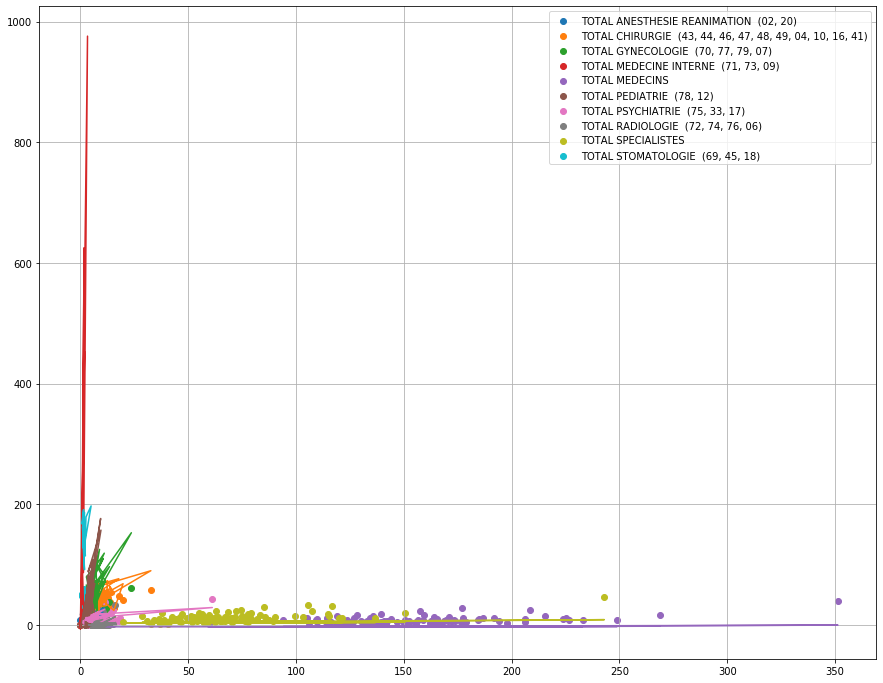

In [22]:
from numpy.polynomial.polynomial import polyfit

fig = plt.figure(figsize=(15.0, 12.0))

plt.grid()
for col in filter_col:
    p = plt.scatter(table_d[col], table_h[col], label=col)
    
    color = p.get_facecolor()[0]
    x = table_d[col].to_numpy()
    y = table_h[col].to_numpy()
    
    idx = np.isfinite(x) & np.isfinite(y)
    
    xx = x[idx].copy()
    yy = y[idx].copy()
    b, m = polyfit(xx, yy, 1)
    plt.plot(xx, b + m * yy, '-', color=color)

plt.legend()
plt.show()

### 3.2 Généralistes

In [23]:
# effectif et densite
generalistes_d = load_ameli_effectif_et_densite_par_departement(sheetname='Généralistes et MEP')

generalistes_d.head()

,categorie,departement,effectifs,population,densite,code_insee
0,01- Médecine générale,01- Ain,387,649699.960030,59.565957,01
1,01- Médecine générale,02- Aisne,347,534299.967129,64.944792,02
2,01- Médecine générale,03- Allier,239,338999.979144,70.501479,03
3,01- Médecine générale,04- Alpes-Hte-Provence,160,161699.990052,98.948676,04
4,01- Médecine générale,05- Hautes-Alpes,162,141599.991289,114.406787,05


In [24]:
generalistes_d = generalistes_d[generalistes_d['categorie'] == '01- Médecine générale'].copy()

generalistes_d.shape

(101, 6)

In [25]:
load_ameli_honoraires_par_departement
# honoraires
generalistes_h = load_ameli_honoraires_par_departement(sheetname='Généralistes et MEP')

generalistes_h.head()


,categorie,departement,effectifs,honoraires_sans_depassement,depassement,deplacement,honoraires_total,depassement_pc,code_insee
0,01- Médecine générale,01- Ain,387,59613396.14,488569.11,208469.37,60310434.62,0.810091,01
1,01- Médecine générale,02- Aisne,347,68197105.92,313500.44,367892.13,68878498.49,0.455150,02
2,01- Médecine générale,03- Allier,239,37651441.09,48325.41,340808.27,38040574.77,0.127036,03
3,01- Médecine générale,04- Alpes-Hte-Provence,160,23566557.63,95815.57,345064.84,24007438.04,0.399108,04
4,01- Médecine générale,05- Hautes-Alpes,162,20219732.59,144542.57,142182.29,20506457.45,0.704864,05


In [26]:
generalistes_h = generalistes_h[generalistes_h['categorie'] == '01- Médecine générale'].copy()

generalistes_h.shape

(101, 9)

In [27]:
generalistes = pd.merge(generalistes_d, generalistes_h,
                        how='inner',
                        on=['categorie', 'departement', 'effectifs', 'code_insee'])

generalistes.head()

,categorie,departement,effectifs,population,densite,code_insee,honoraires_sans_depassement,depassement,deplacement,honoraires_total,depassement_pc
0,01- Médecine générale,01- Ain,387,649699.960030,59.565957,01,59613396.14,488569.11,208469.37,60310434.62,0.810091
1,01- Médecine générale,02- Aisne,347,534299.967129,64.944792,02,68197105.92,313500.44,367892.13,68878498.49,0.455150
2,01- Médecine générale,03- Allier,239,338999.979144,70.501479,03,37651441.09,48325.41,340808.27,38040574.77,0.127036
3,01- Médecine générale,04- Alpes-Hte-Provence,160,161699.990052,98.948676,04,23566557.63,95815.57,345064.84,24007438.04,0.399108
4,01- Médecine générale,05- Hautes-Alpes,162,141599.991289,114.406787,05,20219732.59,144542.57,142182.29,20506457.45,0.704864


In [28]:
generalistes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 11 columns):
categorie                      101 non-null object
departement                    101 non-null object
effectifs                      101 non-null int64
population                     101 non-null float64
densite                        101 non-null float64
code_insee                     101 non-null object
honoraires_sans_depassement    101 non-null float64
depassement                    101 non-null float64
deplacement                    101 non-null float64
honoraires_total               101 non-null float64
depassement_pc                 101 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 9.5+ KB


In [29]:
result = generalistes.sort_values('depassement_pc', ascending=False)

result.head()

,categorie,departement,effectifs,population,densite,code_insee,honoraires_sans_depassement,depassement,deplacement,honoraires_total,depassement_pc
75,01- Médecine générale,75- Paris (Ville),1766,2.168500e+06,81.438788,75,1.933604e+08,32373746.91,12936.55,2.257471e+08,14.340714
92,01- Médecine générale,92- Hauts-de-Seine,974,1.612800e+06,60.391869,92,1.314305e+08,14907499.19,727.21,1.463387e+08,10.186983
78,01- Médecine générale,78- Yvelines,904,1.438400e+06,62.847612,78,1.338700e+08,7580330.62,14803.31,1.414652e+08,5.358443
69,01- Médecine générale,69- Rhône,1594,1.878100e+06,84.873015,69,2.072483e+08,9787303.28,146795.06,2.171824e+08,4.506489
77,01- Médecine générale,77- Seine-et-Marne,774,1.422700e+06,54.403602,77,1.256752e+08,5888000.78,364339.11,1.319276e+08,4.463056


In [30]:
result.set_index('code_insee')
result.reset_index()
result.head()
#print("{}".format(result.depassement_pc.loc['974']))
#print("{}".format(result.depassement_pc.loc[result['code_insee']=='974'][0]))

,categorie,departement,effectifs,population,densite,code_insee,honoraires_sans_depassement,depassement,deplacement,honoraires_total,depassement_pc
75,01- Médecine générale,75- Paris (Ville),1766,2.168500e+06,81.438788,75,1.933604e+08,32373746.91,12936.55,2.257471e+08,14.340714
92,01- Médecine générale,92- Hauts-de-Seine,974,1.612800e+06,60.391869,92,1.314305e+08,14907499.19,727.21,1.463387e+08,10.186983
78,01- Médecine générale,78- Yvelines,904,1.438400e+06,62.847612,78,1.338700e+08,7580330.62,14803.31,1.414652e+08,5.358443
69,01- Médecine générale,69- Rhône,1594,1.878100e+06,84.873015,69,2.072483e+08,9787303.28,146795.06,2.171824e+08,4.506489
77,01- Médecine générale,77- Seine-et-Marne,774,1.422700e+06,54.403602,77,1.256752e+08,5888000.78,364339.11,1.319276e+08,4.463056


In [31]:
generalistes.dtypes

categorie                       object
departement                     object
effectifs                        int64
population                     float64
densite                        float64
code_insee                      object
honoraires_sans_depassement    float64
depassement                    float64
deplacement                    float64
honoraires_total               float64
depassement_pc                 float64
dtype: object

### Carte *Généraliste et dépassement d'honoraires*

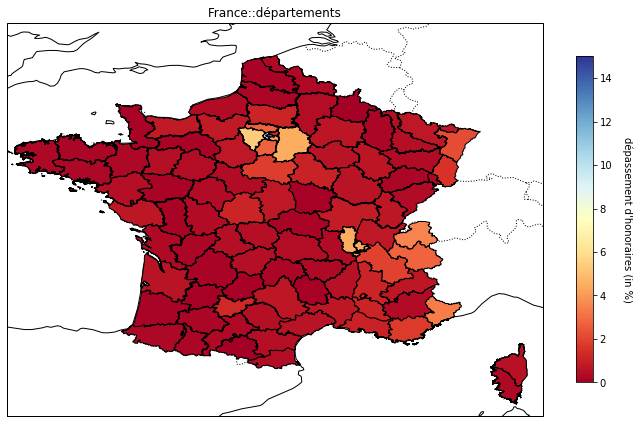

In [32]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

path_to_data = "C:/Users/Thomas/Documents/MyData/departements-20180101-shp/"
shpfilename = path_to_data + "departements-20180101.shp"

reader = shpreader.Reader(shpfilename)

departments = reader.records()

#generalistes.set_index('code_insee')
# min et max
dep_min = int(generalistes['depassement_pc'].min())
dep_max = int(generalistes['depassement_pc'].max()) + 1

cmap = plt.cm.RdYlBu
norm = plt.Normalize(dep_min, dep_max)

# create figure
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title('France::départements')

ax.set_extent([-5.0, 10.0, 41.0, 52.0])

#ax.add_feature(cfeature.OCEAN.with_scale('50m'))
#ax.add_feature(cfeature.RIVERS.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
ax.coastlines('50m')

code_list = generalistes['code_insee'].to_list()
for dept in departments:
    idx = dept.attributes['code_insee']
    if idx in ['69D', '69M']:
        idx = '69'

    if idx in code_list:
        value = generalistes['depassement_pc'].loc[generalistes['code_insee']==idx].iloc[0]
        color = cmap(norm(value))

        # `dept.geometry` is the polygon to plot
        ax.add_geometries([dept.geometry], ccrs.PlateCarree(),
                          facecolor=color, edgecolor='black')

# Make a 'colorbar'
# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=.5)
cbar.set_label("dépassement d'honoraires (in %)", labelpad=20, rotation=270)

plt.show()

In [33]:
### Carte *Généraliste et densité*

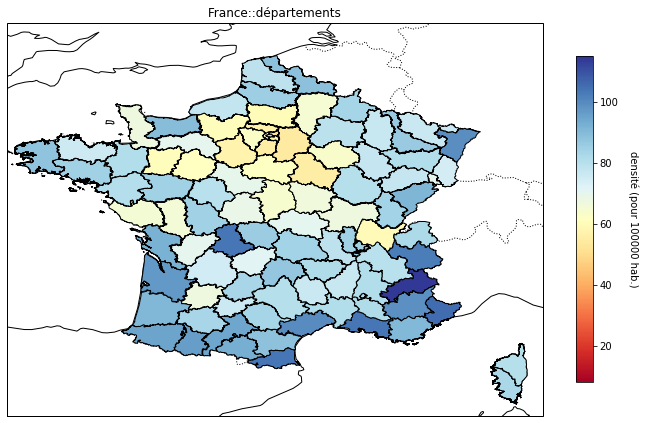

In [38]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from mpl_toolkits.axes_grid1 import make_axes_locatable

path_to_data = "C:/Users/Thomas/Documents/MyData/departements-20180101-shp/"
shpfilename = path_to_data + "departements-20180101.shp"

reader = shpreader.Reader(shpfilename)

departments = reader.records()

# min et max
dep_min = int(generalistes['densite'].min())
dep_max = int(generalistes['densite'].max()) + 1

cmap = plt.cm.RdYlBu
norm = plt.Normalize(dep_min, dep_max)

# create figure
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title('France::départements')

ax.set_extent([-5.0, 10.0, 41.0, 52.0])

#ax.add_feature(cfeature.OCEAN.with_scale('50m'))
#ax.add_feature(cfeature.RIVERS.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
ax.coastlines('50m')

code_list = generalistes['code_insee'].to_list()
for dept in departments:
    idx = dept.attributes['code_insee']
    if idx in ['69D', '69M']:
        idx = '69'
    
    if idx in code_list:
        
        value = generalistes['densite'].loc[generalistes['code_insee']==idx].iloc[0]
        color = cmap(norm(value))

        # `dept.geometry` is the polygon to plot
        ax.add_geometries([dept.geometry], ccrs.PlateCarree(),
                          facecolor=color, edgecolor='black')

# Make a 'colorbar'
# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=.5)
cbar.set_label("densité (pour 100000 hab.)", labelpad=20, rotation=270)

plt.show()